# A Neural Network for Regression (Estimate blood pressure from PPG signal)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

Having gained some experience with neural networks, let us train a network that estimates the blood pressure from a PPG signal window.

All of your work for this exercise will be done in this notebook.

# A Photoplethysmograph (PPG) signal

A PPG (photoplethysmograph) signal is a signal obtained with a pulse oximeter, which illuminates the skin and measures changes in light absorption. A PPG signal carries rich information about the status of the cardiovascular health of a person, such as breadth rate, heart rate and blood pressure. An example is shown below, where you also see the blood pressure signal that we will estimate (the data also has the ECG signal, which you should ignore).

<img width="80%" src="PPG_ABG_ECG_example.png">


# Constructing the Dataset 

In this task, you are expected to perform the full pipeline for creating a learning system from scratch. Here is how you should construct the dataset:
* Download the dataset from the following website, and only take "Part 1" from it (it is too big): https://archive.ics.uci.edu/ml/datasets/Cuff-Less+Blood+Pressure+Estimation
* Take a window of size $W$ from the PPG channel between time $t$ and $t+W$. Let us call this $\textbf{x}_t$.
* Take the corresponding window of size $W$ from the ABP (arterial blood pressure) channel between time $t$ and $t+W$. Find the maxima and minima of this signal within the window (you can use "findpeaks" from Matlab or "find_peaks_cwt" from scipy). Here is an example window from the ABP signal, and its peaks:
 <img width="60%" src="ABP_peaks.png">
    
* Calculate the average of the maxima, call it $y^1_t$, and the average of the minima, call it $y^2_t$.
* Slide the window over the PPG signals and collect many $(\textbf{x}_t, <y^1_t, y^2_t>)$ instances. In other words, your network outputs two values.
* This will be your input-output for training the network.

In [1]:
import random
import numpy as np
from metu.data_utils import load_dataset
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import h5py
import scipy.signal as signal
#import analytic_wfm as AW
#from peakdetect import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2
#store data in the array of 3 columns
#1 - PPG 2 - APB 3 - ECG
#with h5py.File('Part_2.mat', 'r') as f:
#    Part = f['Part_2']
#    dataset = np.array(f[Part[0].item()].value)
#    f.close()
#t = 0
#W = 250
#i = 0
#X = np.zeros((size, W))
#y = []
#find peaks in array of APB in the array 
#of size W (sample slice (t, W+t) taken from dataset[:, 1])
#while t<dataset.shape[0]:
#    X[i, :] = np.array(dataset[t:W+t, 0]).reshape(W, 1).T
#    abp = np.array(np.ravel(dataset[t:W+t, 1].reshape(W, 1).T))
    #local maxima
#    max_peaks = peakutils.indexes(abp, min_dist=50)
    #local minima
#    abp1 =1./abp
#    min_peaks = peakutils.indexes(abp1, min_dist=50)
    #means
#    minp = np.mean([abp[k] for k in min_peaks])
#    maxp = np.mean([abp[k] for k in max_peaks])
    
#    y.append((maxp, minp))
#    t+=W
#    i+=1

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.
from cs231n.classifiers.neural_net_for_regression import TwoLayerNet

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4], [2, 1, 4], [2, 1, 4]])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net_for_regression.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the previous exercises: It takes the data and weights and computes the *regression* scores, the squared error loss, and the gradients on the parameters. 

To be more specific, you will implement the following loss function:

$$\frac{1}{2}\sum_i\sum_{j} (o_{ij} - y_{ij})^2 + \frac{1}{2}\lambda\sum_j w_j^2,$$

where $i$ runs through the samples in the batch; $o_{ij}$ is the prediction of the network for the $i^{th}$ sample for output $j$, and $y_{ij}$ is the correct value; $\lambda$ is the weight of the regularization term.

The first layer uses ReLU as the activation function. The output layer does not use any activation functions.

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
a = np.array([[1, 0], [1, 1]])
b = np.array([[4, 3], [2, 2]])
print(a.dot(b))
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

[[4 3]
 [6 5]]
Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
0.0


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 66.3406756909
print(loss)
# should be very small, we get < 1e-10
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

66.3406756781
Difference between your loss and correct loss:
1.28444526126e-08


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name])
  #print(param_name, net.params[param_name])
  print('{:s} max relative error: {:e}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 9.783744e-04
b1 max relative error: 2.866381e-03
W2 max relative error: 5.192568e-04
b2 max relative error: 1.443396e-06


# Load the PPG dataset for training your regression network

In [6]:
# Load the PPG dataset
# If your memory turns out to be sufficient, try loading a subset
def get_data(datafile, input_size, min_dist, training_ratio=0.85, test_ratio=0.1, val_ratio=0.05):
  # Load the PPG training data 
  X, y = load_dataset(datafile, input_size, min_dist)
    
  # TODO: Split the data into training, validation and test sets
  length=y.shape[0]
  print(length)
  num_training=int(length*training_ratio)
  num_val = int(length*val_ratio)
  num_test = min((length-num_training-num_val), int(length*test_ratio))
  mask = range(num_training-1)
  X_train = X[mask]
  y_train = y[mask]
  mask = range(num_training, num_training+num_test)
  X_test = X[mask]
  y_test = y[mask]
  mask = range(num_training+num_test, num_training+num_test+num_val)
  X_val = X[mask]
  y_val = y[mask]
  
  return X_train, y_train, X_val, y_val, X_test, y_test

datafile = 'Part_2.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile, 1000, 50)
print("Number of instances in the training set: ", len(X_train))
print("Number of instances in the validation set: ", len(X_val))
print("Number of instances in the testing set: ", len(X_test))

57
Number of instances in the training set:  47
Number of instances in the validation set:  2
Number of instances in the testing set:  5


# Now train our network on the PPG dataset

In [7]:
# Now, let's train a neural network

input_size = input_size
hidden_size = 500 # TODO: Choose a suitable hidden layer size
num_classes = 2 # We have two outputs
net = TwoLayerNet(input_size, hidden_size, num_classes)
# Train the network
stats = net.train(X_train, y_train, X_val, y_val, learning_rate=1e-5, learning_rate_decay=0.95, reg=0.5, num_iters=5000, batch_size=32,verbose=True)

# Predict on the validation set
#val_err = ... # TODO: Perform prediction on the validation set

val_err = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
print('Validation error: ', val_err)

iteration 0 / 5000: loss 7541.986117
iteration 100 / 5000: loss 7531.761004
iteration 200 / 5000: loss 7523.720613
iteration 300 / 5000: loss 7514.756031
iteration 400 / 5000: loss 1.031111
iteration 500 / 5000: loss 7439.633071
iteration 600 / 5000: loss 7194.155516
iteration 700 / 5000: loss 2.865658
iteration 800 / 5000: loss 4.362320
iteration 900 / 5000: loss 2230.913866
iteration 1000 / 5000: loss 690.442074
iteration 1100 / 5000: loss 181.734160
iteration 1200 / 5000: loss 55.411435
iteration 1300 / 5000: loss 22.264757
iteration 1400 / 5000: loss 13.218272
iteration 1500 / 5000: loss 10.200819
iteration 1600 / 5000: loss 8.596948
iteration 1700 / 5000: loss 8.226259
iteration 1800 / 5000: loss 7.930614
iteration 1900 / 5000: loss 7.643319
iteration 2000 / 5000: loss 7.417014
iteration 2100 / 5000: loss 7.223856
iteration 2200 / 5000: loss 6.979904
iteration 2300 / 5000: loss 6.916640
iteration 2400 / 5000: loss 6.714074
iteration 2500 / 5000: loss 6.688364
iteration 2600 / 5000

# Debug the training and improve learning
You should be able to get a validation error of 5.

So far so good. But, is it really good? Let us plot the validation and training errors to see how good the network did. Did it memorize or generalize? Discuss your observations and conclusions. If its performance is not looking good, propose and test measures. This is the part that will show me how well you have digested everything covered in the lectures.

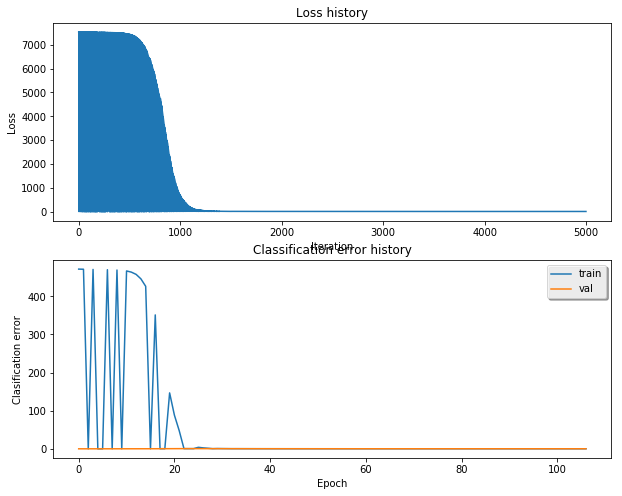

In [8]:
# Plot the loss function and train / validation errors
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
train = plt.plot(stats['train_err_history'], label='train')
val = plt.plot(stats['val_err_history'], label='val')
plt.legend(loc='upper right', shadow=True)
plt.title('Classification error history')
plt.xlabel('Epoch')
plt.ylabel('Clasification error')
plt.show()

# Finetuning and Improving Your Network (Bonus)
There are many aspects and hyper-parameters you can play with. Do play with them and find the best setting here.

In [27]:
import math
best_net = None
best_val = math.inf
results = {}
learning_rates = [1.1e-3,1.4e-3,1.8e-3]
regularization_strengths = [8e-2,3e-1,8e-1]    
input_size = [250, 500, 1000]
hidden_size = [50, 300, 650]
min_dist = [25, 50, 100]
num_classes = 2    
k=0
while k<len(hidden_size):
    i=0
    while i< len(learning_rates):
        j = 0
        while j < len(regularization_strengths):
            t = 0
            while t < len(input_size):
                m = 0
                while m<len(hidden_size):
                    z = 0
                    while z<len(min_dist):
                        X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile, input_size[t], min_dist[z])
                        net = TwoLayerNet(input_size[t], hidden_size[k], num_classes)
                        stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=2000, batch_size=200,
                        learning_rate=learning_rates[i], learning_rate_decay=0.95,
                        reg=regularization_strengths[j])
                        #np.array([1 if a[0] == b[0] and a[1]==b[1] else 0 for (a, b) in zip(net.predict(X_val), y_val)]).mean()
                        val_err = net.loss(X_val, y_val)[0]
                        train_err = net.loss(X_train, y_train)[0]                     
                        if best_val > val_err:
                            best_val = val_err
                            best_net = net
                        results[(hidden_size[k], learning_rates[i], regularization_strengths[j], input_size[t], hidden_size[m], min_dist[z])] = (train_err, val_err)
                        z=z+1
                    m+=1
                t+=1
            j=j+1
        i=i+1
    k=k+1
results = sorted(results.items(), key=lambda x:x[1][1], reverse=False)
for tup in results:
    print('hs: {:e} lr: {:e} reg: {:e} inz: {:e} hidz: {:e} mind: {:e} train err: {:f} val err: {:f}'.format(
                tup[0][0], tup[0][1], tup[0][2], tup[0][3], tup[0][4], tup[0][5], tup[1][0], tup[1][1]))
    
print('best validation accuracy achieved during cross-validation: {:f}'.format(best_val))




228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
228
228
228
228
228
228
228
114
114
114
114
114
114
114
114
114
57
57
57
57
57
57
57
57
57
228
228
22

hs: 5.000000e+01 lr: 1.100000e-03 reg: 8.000000e-01 inz: 2.500000e+02 hidz: 3.000000e+02 mind: 2.500000e+01 train err: 1.106326 val err: 0.063344
hs: 5.000000e+01 lr: 1.100000e-03 reg: 3.000000e-01 inz: 2.500000e+02 hidz: 6.500000e+02 mind: 2.500000e+01 train err: 1.102969 val err: 0.063450
hs: 5.000000e+01 lr: 1.100000e-03 reg: 8.000000e-02 inz: 2.500000e+02 hidz: 6.500000e+02 mind: 2.500000e+01 train err: 1.108558 val err: 0.063830
hs: 5.000000e+01 lr: 1.400000e-03 reg: 8.000000e-02 inz: 5.000000e+02 hidz: 6.500000e+02 mind: 2.500000e+01 train err: 1.203284 val err: 0.064000
hs: 5.000000e+01 lr: 1.400000e-03 reg: 3.000000e-01 inz: 5.000000e+02 hidz: 5.000000e+01 mind: 2.500000e+01 train err: 1.205708 val err: 0.064107
hs: 6.500000e+02 lr: 1.800000e-03 reg: 8.000000e-01 inz: 5.000000e+02 hidz: 6.500000e+02 mind: 5.000000e+01 train err: 1.215379 val err: 0.064498
hs: 5.000000e+01 lr: 1.100000e-03 reg: 3.000000e-01 inz: 2.500000e+02 hidz: 6.500000e+02 mind: 5.000000e+01 train err: 1.121

In [49]:
learning_rate = results[0][0][1]
reg_s = results[0][0][2]   
input_size = results[0][0][3]
hidden_size = results[0][0][0]
min_dist = results[0][0][5]
print('Best hyper parameters are: \n learning rate - {:f}, regularization strength - {:f},\n input size - {:d}, hidden-layer_size - {:d}, min dist - {:d}'.format(learning_rate, reg_s, input_size, hidden_size, min_dist))
print('Best validation error achieved during cross-validation: {:f}'.format(results[0][1][1]))

Best hyper parameters are: 
 learning rate - 0.001800, regularization strength - 0.080000,
 input size - 250, hidden-layer_size - 650, min dist - 25
Best validation error achieved during cross-validation: 0.000099


# Run on the test set

In [50]:
input_size = results[0][0][3]
min_dist = results[0][0][5]
reg_s = results[0][0][2]
X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile, input_size, min_dist)
y_pred = best_net.predict(X_test)
loss = 0.5*np.sum((y_pred - y_test)**2) + 0.5*reg_s*np.sum(best_net.params['W2']**2)+0.5*reg_s*np.sum(best_net.params['W1']**2)
print('Test err: ', loss)

228
Test err:  1.28179875882
